## Space/Time model order reduction

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ezyrb import SpaceTimePOD, SpaceTimeDatabase, POD

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


## Dataset

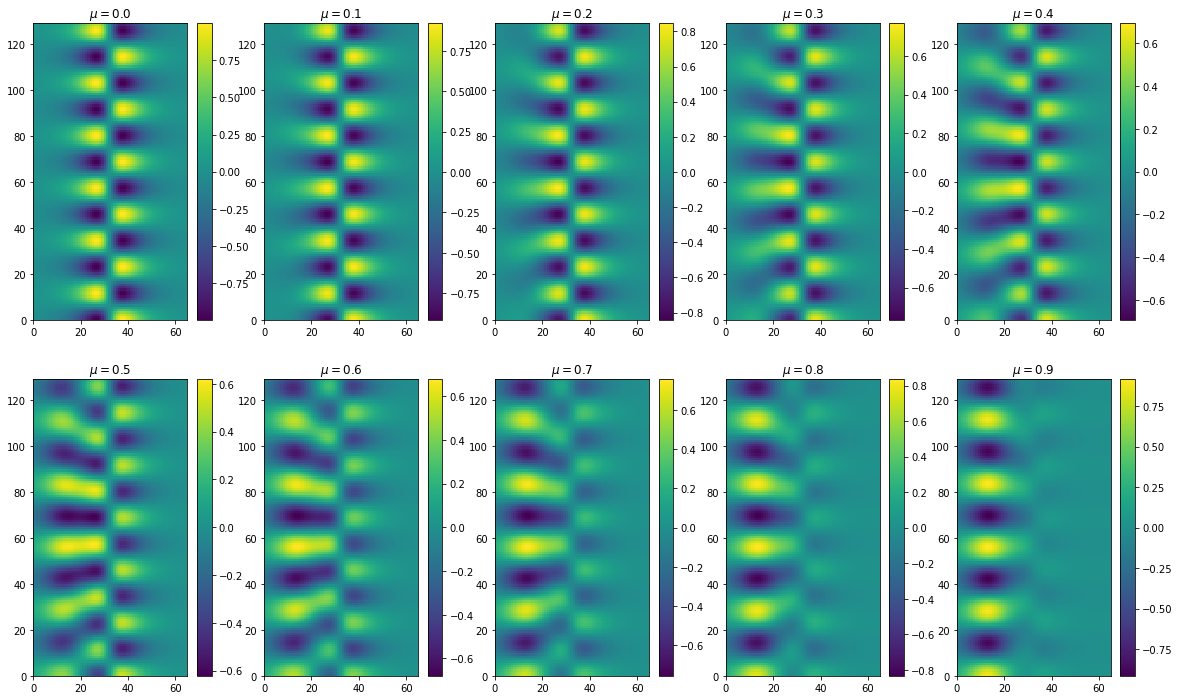

In [2]:
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

x = np.linspace(-5, 5, 65)
t = np.linspace(0, 4*np.pi, 129)

xgrid, tgrid = np.meshgrid(x, t)

Y1 = f1(xgrid, tgrid)
Y2 = f2(xgrid, tgrid)

mus = [round(mu,1) for mu in np.linspace(0,0.9,10)]

Y = np.array([
    mu * Y1 + (1-mu) * Y2 for mu in mus
])

Y = np.swapaxes(Y,1,2)
Y.shape

plt.figure(figsize=(20,12))
for i in range(Y.shape[0]):
    plt.subplot(2, 5, i+1)
    plt.pcolor(Y[i].T.real)
    plt.colorbar()
    plt.title('$\mu = {}$'.format(mus[i]))
plt.show()

## Double POD

In [3]:
# to be consistent with dimensions used in Database and ReducedOrderModel
X = Y.T
    
stPOD = SpaceTimePOD(method='nested',spatial_pod_args={'rank':0.99999}, temporal_pod_args={'rank':0.99999})
coeffs = stPOD.reduce(X)

## Modes

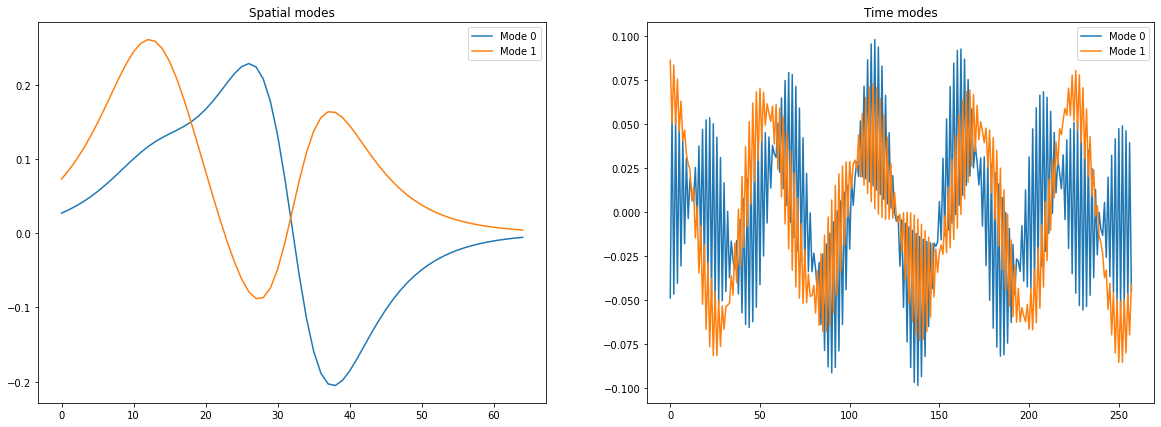

In [4]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
for idx,mode in enumerate(stPOD._spatial_pod.modes.T):
    plt.plot(mode, label='Mode {}'.format(idx))
plt.title('Spatial modes')
plt.legend()

plt.subplot(1,2,2)
for idx,mode in enumerate(stPOD._temporal_pod.modes.T):
    plt.plot(mode, label='Mode {}'.format(idx))
plt.legend()
plt.title('Time modes')

plt.show();

## Modal coefficients

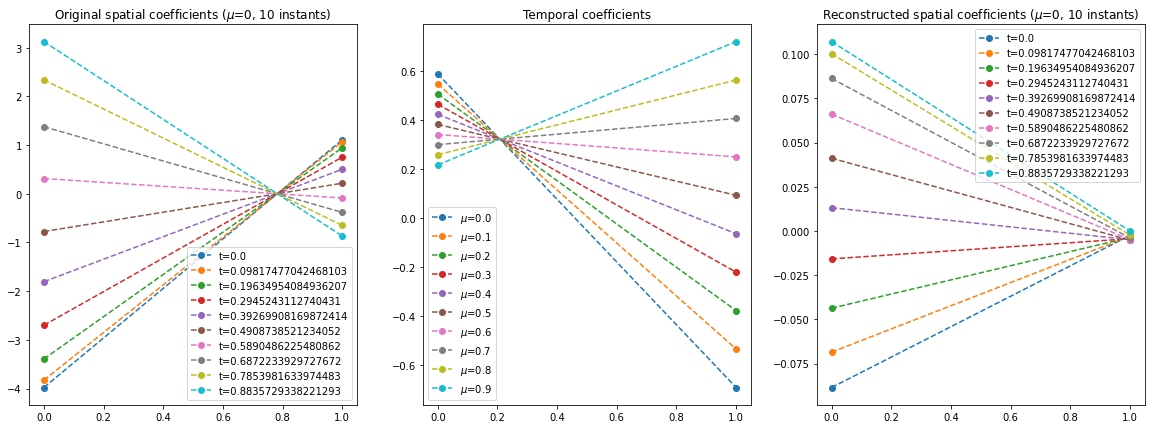

In [5]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
for idx,column in enumerate(stPOD._spatial_modal_coeffs.T[:10]):
    plt.plot(column, linestyle='--', marker='o', label='t={}'.format(t[idx]))
plt.title('Original spatial coefficients ($\mu$=0, 10 instants)')
plt.legend()

plt.subplot(1,3,2)
for idx,column in enumerate(coeffs.T):
    plt.plot(column, linestyle='--', marker='o', label='$\mu$={}'.format(mus[idx]))
plt.legend()
plt.title('Temporal coefficients')

coeffs_timemu = np.reshape(stPOD._temporal_pod.expand(coeffs).T,
                (-1, stPOD._time_instants * stPOD._ntrain), 'F')
plt.subplot(1,3,3)
for idx,column in enumerate(coeffs_timemu.T[:10]):
    plt.plot(column, linestyle='--', marker='o', label='t={}'.format(t[idx]))
plt.title('Reconstructed spatial coefficients ($\mu$=0, 10 instants)')
plt.legend()

plt.show();

## Reconstructed data

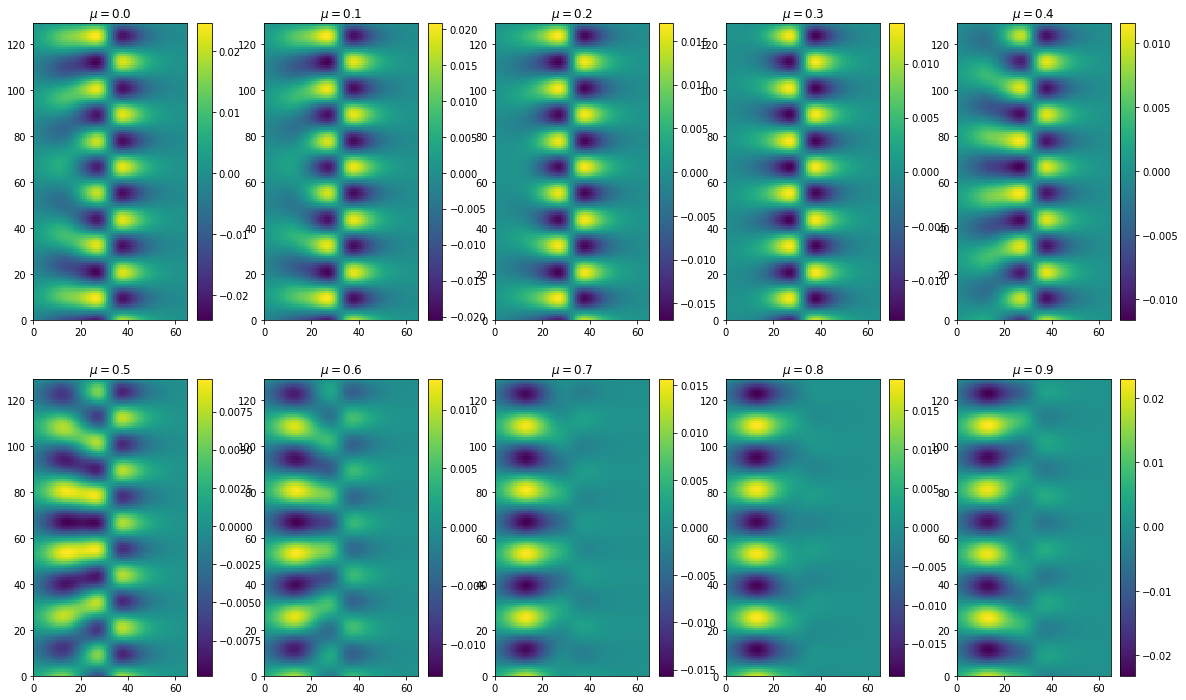

In [6]:
reconstructed = stPOD.expand(coeffs)

plt.figure(figsize=(20,12))
for i in range(reconstructed.shape[2]):
    plt.subplot(2, 5, i+1)
    plt.pcolor(reconstructed[:,:,i].real)
    plt.colorbar()
    plt.title('$\mu = {}$'.format(mus[i]))
plt.show()

## Error

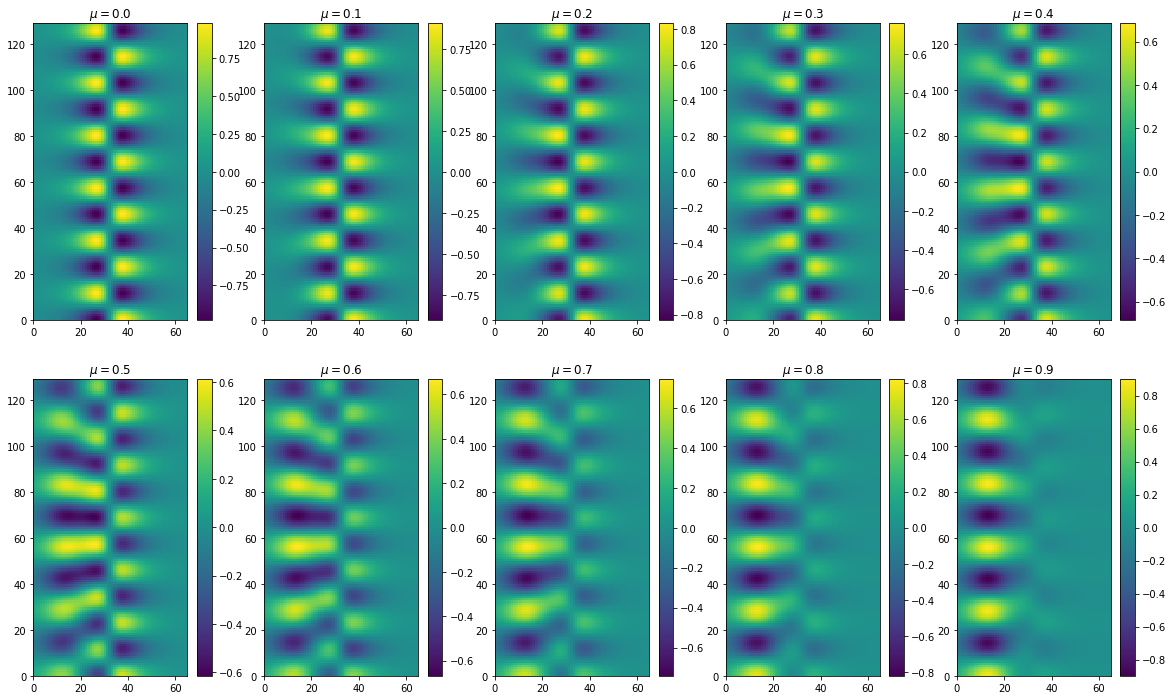

In [7]:
plt.figure(figsize=(20,12))
for i in range(reconstructed.shape[2]):
    plt.subplot(2, 5, i+1)
    plt.pcolor((Y[i].T - reconstructed[:,:,i]).real)
    plt.colorbar()
    plt.title('$\mu = {}$'.format(mus[i]))
plt.show()